In [ ]:
import pandas as pd
import numpy as np
from numpy import random
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

random_state=42

In [ ]:
train_csv=pd.read_csv('train.csv')
test_csv=pd.read_csv('test.csv')
train_csv['file']='train'
test_csv['file']='test'
test_csv['SalePrice']= -1
df=pd.concat([train_csv, test_csv], ignore_index=True)
df=df.drop(['Id'], axis=1, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [ ]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,file
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2006,WD,Normal,-1,test
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,-1,test
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,-1,test
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,-1,test


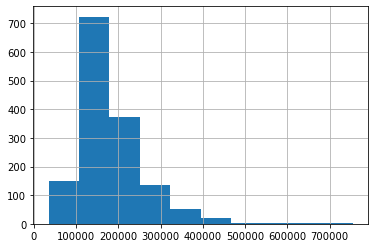

In [ ]:
train_csv['SalePrice'].hist()

Target label is skewed (positive skew), hence might affect modeling if left untouched.

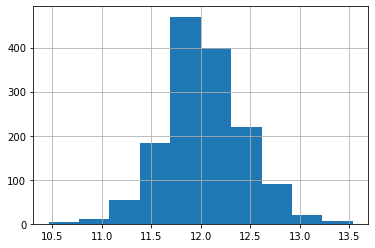

In [ ]:
np.log1p(train_csv['SalePrice']).hist() # log transformation.
df['SalePrice'] = pd.concat([np.log1p(train_csv['SalePrice']), test_csv['SalePrice']], ignore_index=True)

Encoding some categoricals as ordinals:

In [ ]:
dict_ordinals={}
dict_ordinals['Street']={'Grvl':1, 'Pave':2}
dict_ordinals['Alley']={'Grvl':1, 'Pave':2}
dict_ordinals['LotShape']={'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}
dict_ordinals['Utilities']={'AllPub':1, 'NoSewr':2, 'NoSeWa':3, 'ELO':4}
dict_ordinals['LandSlope']={'Gtl':1, 'Mod':2, 'Sev':3}
dict_ordinals['ExterQual']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['ExterCond']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['BsmtQual']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['BsmtCond']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['BsmtExposure']={'Gd':1, 'Av':2, 'Mn':3, 'No':4}
dict_ordinals['BsmtFinType1']={'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6}
dict_ordinals['BsmtFinType2']={'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6}
dict_ordinals['KitchenQual']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['Functional']={'Typ':1, 'Min1':2, 'Min2':3, 'Mod':4, 
                             'Maj1':5, 'Maj2':6, 'Sev': 7, 'Sal':8}
dict_ordinals['FireplaceQu']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['GarageType']={'2Types':1, 'Attchd':2, 'Basment':3, 
                             'BuiltIn':4, 'CarPort':5, 'Detchd':6}
dict_ordinals['GarageFinish']={'Fin':1, 'RFn':2, 'Unf':3}
dict_ordinals['GarageQual']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['GarageCond']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5}
dict_ordinals['PavedDrive']={'Y':1, 'P':2, 'N':3}
dict_ordinals['PoolQC']={'Ex':1, 'Gd':2, 'TA':3, 'Fa':4}
dict_ordinals['Fence']={'GdPrv':1, 'MnPrv':2, 'GdWo':3, 'MnWw':4}



df=df.replace(dict_ordinals)

Creating new features (#1):

In [ ]:
df['years_since_built']=df['YrSold']-df['YearBuilt']
df['years_since_remodeled']=df['YrSold']-df['YearRemodAdd']
df['years_garage']=df['YrSold']-df['GarageYrBlt']
df=df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'],
          axis=1, errors='ignore')

Converting some numericals to categorical:

In [ ]:
df['YrSold']=df['YrSold'].apply(str)
df['MoSold']=df['MoSold'].apply(str)
df['MSSubClass']=df['MSSubClass'].apply(str)

Filling current NA's for columns with specified information in the 'data_description' about their values (most are ordinal features):

In [ ]:
df['Alley']=df['Alley'].fillna(0)
df['BsmtQual']=df['BsmtQual'].fillna(6)
df['BsmtCond']=df['BsmtCond'].fillna(6)
df['BsmtExposure']=df['BsmtExposure'].fillna(5)
df['BsmtFinType1']=df['BsmtFinType1'].fillna(7)
df['BsmtFinType2']=df['BsmtFinType2'].fillna(7)
df['FireplaceQu']=df['FireplaceQu'].fillna(6)
df['GarageType']=df['GarageType'].fillna(7)
df['GarageFinish']=df['GarageFinish'].fillna(4)
df['GarageQual']=df['GarageQual'].fillna(6)
df['GarageCond']=df['GarageCond'].fillna(6)
df['PoolQC']=df['PoolQC'].fillna(5)
df['Fence']=df['Fence'].fillna(5)
df['MiscFeature']=df['MiscFeature'].fillna('None')


Counting null values (in the train set only).
Unlike before, this is a phase that leads to decision on the data, hence we are leaving the test aside.

In [ ]:
train_nulls=df[df['file']=='train'].isnull().sum()
train_nulls=train_nulls[train_nulls>0]
train_nulls=train_nulls.sort_values(ascending=False)
display(train_nulls)

LotFrontage     259
years_garage     81
MasVnrArea        8
MasVnrType        8
Electrical        1
dtype: int64

Dropping columns with too many nulls.
Since we already have a lot of features, we will delete this one. We will drop more columns later.

In [ ]:
df=df.drop(['LotFrontage'], axis=1, errors='ignore') # about (1/6) of the values is missing.

Filling missing values with median/mode values:

In [ ]:
# Numericals
numerical_columns_df=df.select_dtypes(exclude=['object'])   
numerical_columns_df=numerical_columns_df.fillna(numerical_columns_df.median())
# Categoricals
categorical_columns_df=df.select_dtypes(include=['object'])  
categorical_columns_df=categorical_columns_df.fillna(categorical_columns_df.mode().iloc[0])
df=pd.concat([numerical_columns_df, categorical_columns_df], axis=1)

In [ ]:
df

,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,Heating,HeatingQC,CentralAir,Electrical,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,file
0,8450,2,0.0,1,1.0,1,7,5,196.0,2,...,GasA,Ex,Y,SBrkr,None,2,2008,WD,Normal,train
1,9600,2,0.0,1,1.0,1,6,8,0.0,3,...,GasA,Ex,Y,SBrkr,None,5,2007,WD,Normal,train
2,11250,2,0.0,2,1.0,1,7,5,162.0,2,...,GasA,Ex,Y,SBrkr,None,9,2008,WD,Normal,train
3,9550,2,0.0,2,1.0,1,7,5,0.0,3,...,GasA,Gd,Y,SBrkr,None,2,2006,WD,Abnorml,train
4,14260,2,0.0,2,1.0,1,8,5,350.0,2,...,GasA,Ex,Y,SBrkr,None,12,2008,WD,Normal,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1936,2,0.0,1,1.0,1,4,7,0.0,3,...,GasA,Gd,Y,SBrkr,None,6,2006,WD,Normal,test
2915,1894,2,0.0,1,1.0,1,4,5,0.0,3,...,GasA,TA,Y,SBrkr,None,4,2006,WD,Abnorml,test
2916,20000,2,0.0,1,1.0,1,5,7,0.0,3,...,GasA,Ex,Y,SBrkr,None,9,2006,WD,Abnorml,test
2917,10441,2,0.0,1,1.0,1,5,5,0.0,3,...,GasA,TA,Y,SBrkr,Shed,7,2006,WD,Normal,test


Creating new features (#2):

In [ ]:
df["TotalBath"]=df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
                df["FullBath"] + (0.5 * df["HalfBath"])
df["AllPorchSF"]=df["OpenPorchSF"] + df["EnclosedPorch"] + \
                df["3SsnPorch"] + df["ScreenPorch"]
df["AllSF"]=df["GrLivArea"] + df["TotalBsmtSF"]
df["AllFlrsSF"]=df["1stFlrSF"] + df["2ndFlrSF"]
df["PoolScore"]=df["PoolArea"] * df["PoolQC"]
df["OverallGrade"]=df["OverallQual"] * df["OverallCond"]
df["GarageGrade"]=df["GarageQual"] * df["GarageCond"]
df["ExterGrade"]=df["ExterQual"] * df["ExterCond"]
df["KitchenScore"]=df["KitchenAbvGr"] * df["KitchenQual"]
df["FireplaceScore"]=df["Fireplaces"] * df["FireplaceQu"]
df["GarageScore"]=df["GarageArea"] * df["GarageQual"]
df["HasMasVnr"]=df['MasVnrType'].replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
df["BoughtOffPlan"]=df['SaleCondition'].replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1283EB38>,
      dtype=object)

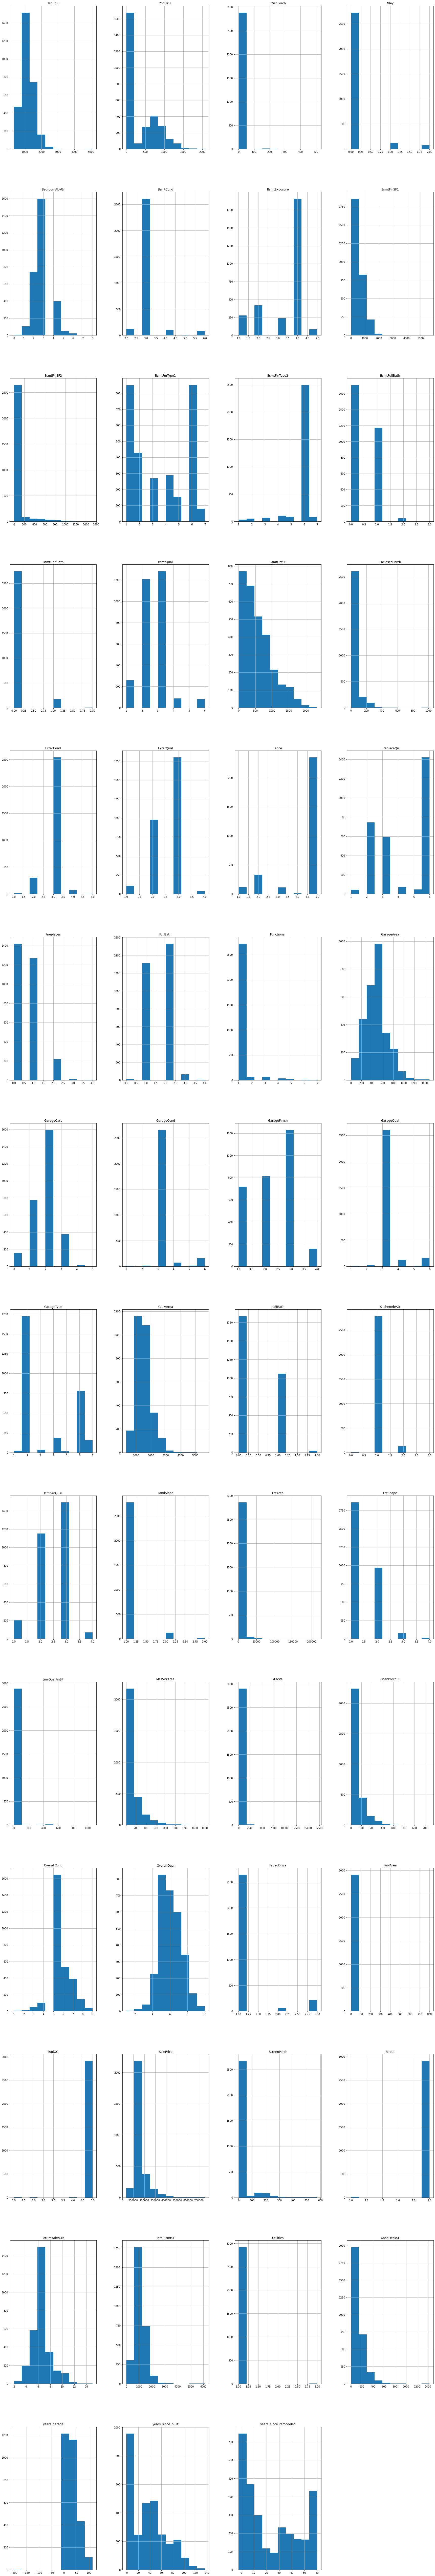

In [ ]:
numerical_columns_df.hist(figsize=(30,200), layout=(15,4))

Some features don't contain almost any variation at all.

In [ ]:
cols_to_drop=['3SsnPorch', 'LotArea', 'LowQualFinSF', 'MiscVal', 'PoolArea', 'PoolQC', 'Street', 'Utilities']

Moving on to categorical features:

e:\softwares\python\lib\site-packages\seaborn\axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


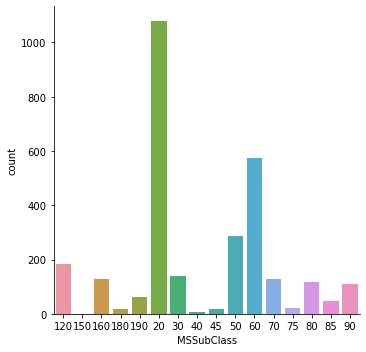

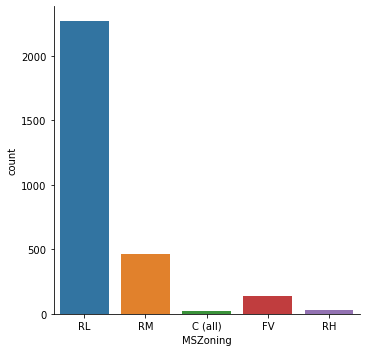

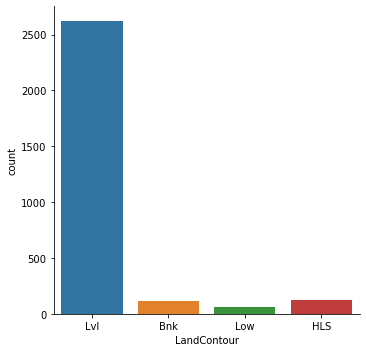

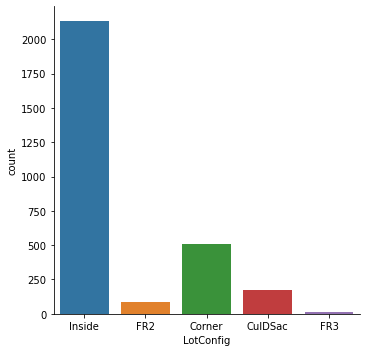

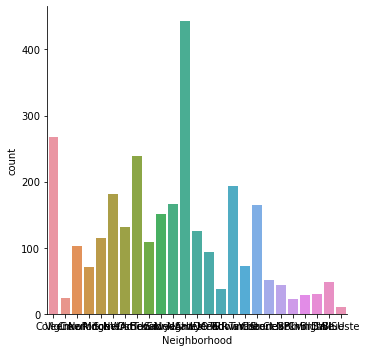

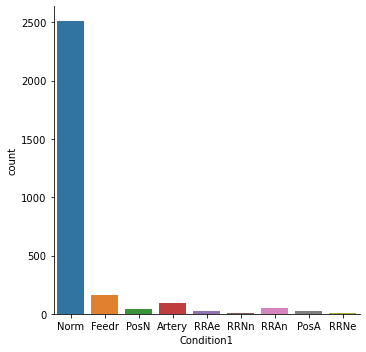

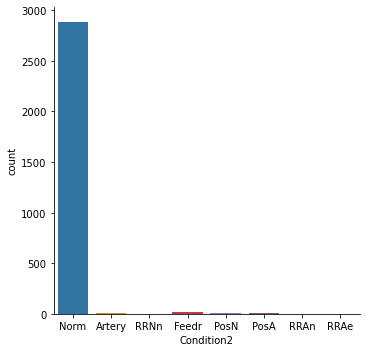

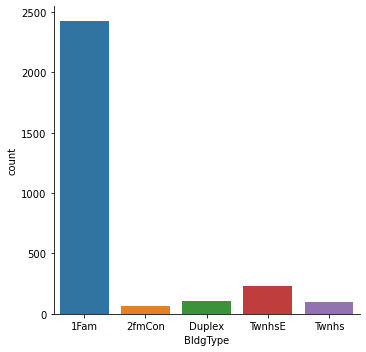

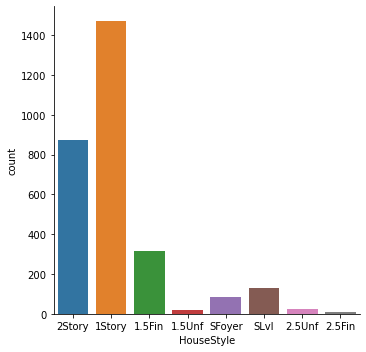

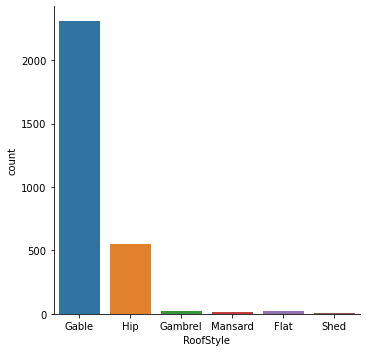

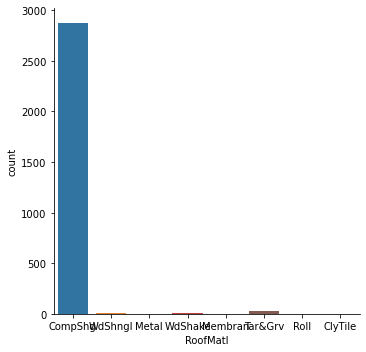

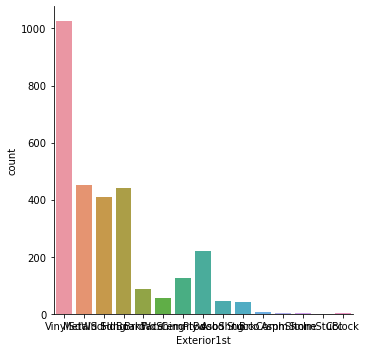

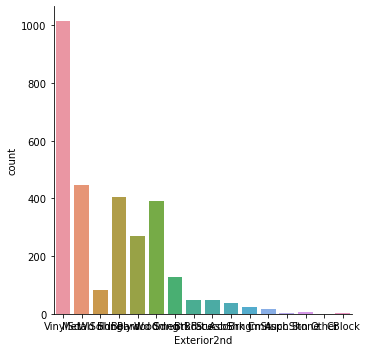

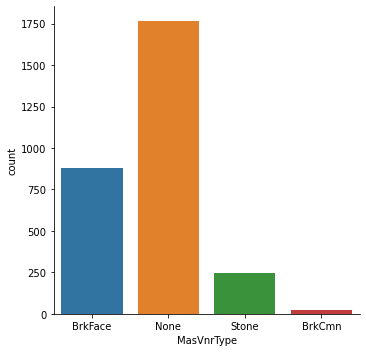

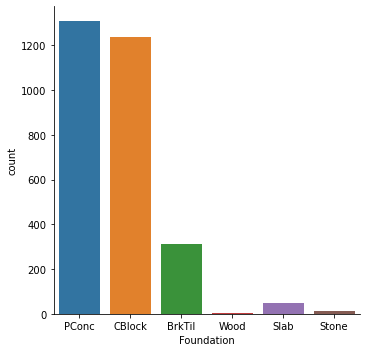

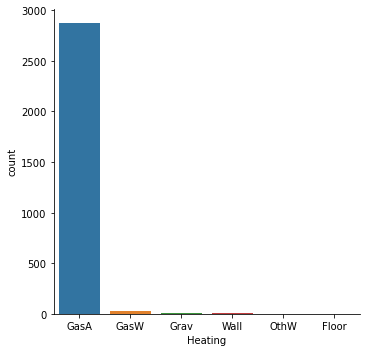

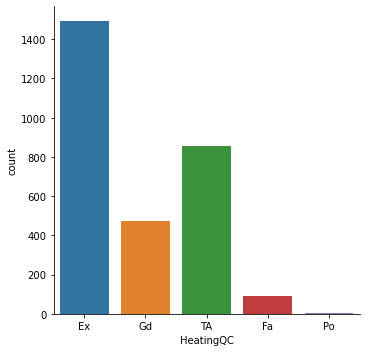

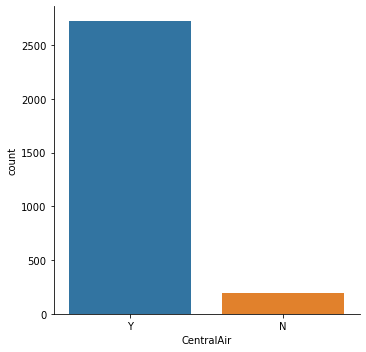

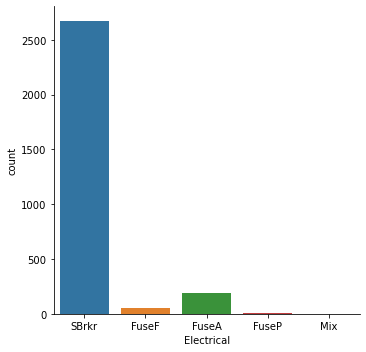

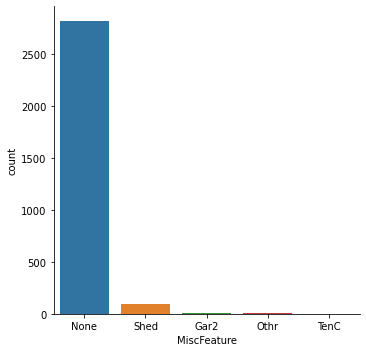

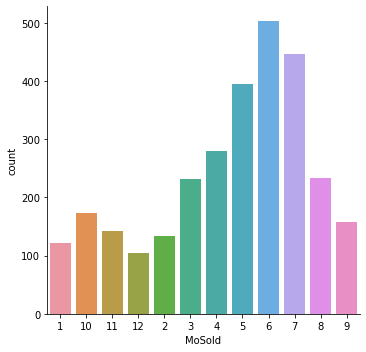

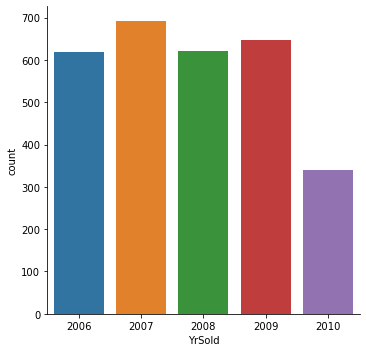

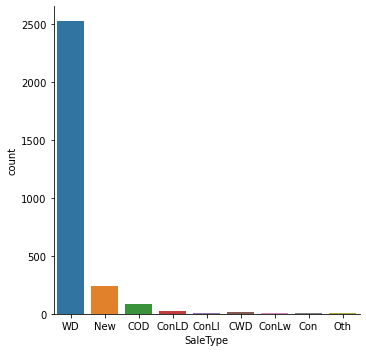

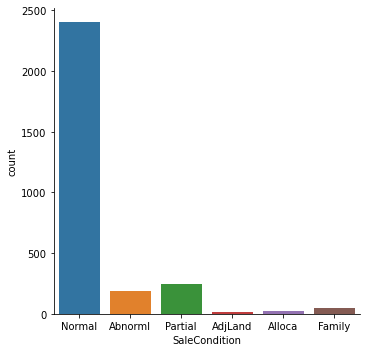

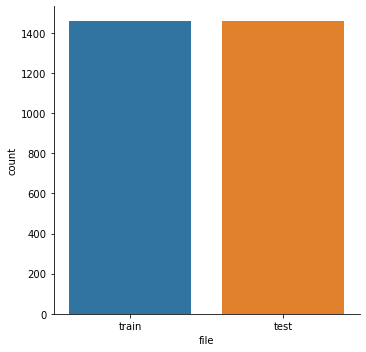

In [ ]:
object_columns_df = df.select_dtypes(include=['object'])   
for col in object_columns_df.columns:
    sns.catplot(x=col, kind="count", data=object_columns_df)
    #ax = sns.countplot(x=col, data=object_columns_df)

Some features don't contain almost any variation at all:

In [ ]:
cols_to_drop+=['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
df=df.drop(cols_to_drop, axis=1, errors='ignore') # 11 columns in total.

Looking for outliers (in train only):

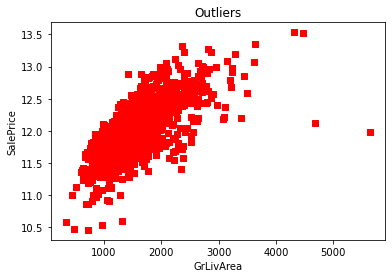

In [ ]:
train=df[df['file']=='train']
plt.scatter(train['GrLivArea'], train['SalePrice'], c = "red", marker = "s")
plt.title("Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [ ]:
df=df.drop(train[train['GrLivArea']>4000].index, errors='ignore')

Plotting 30 highly correlated numerical/ordinal features to the target.

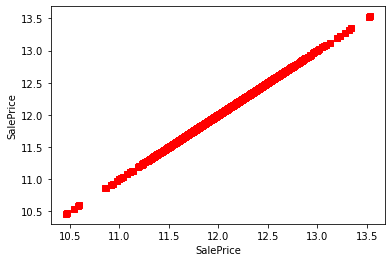

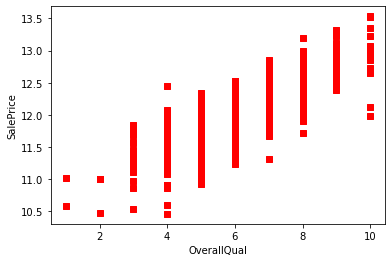

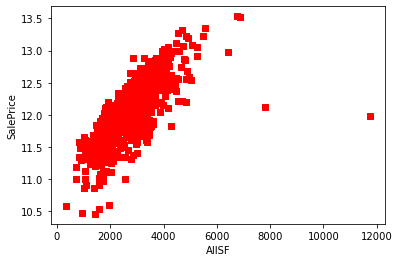

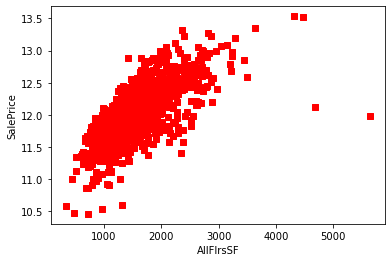

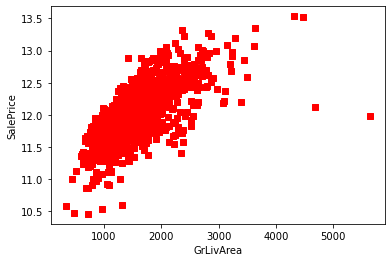

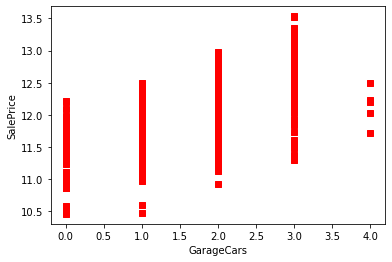

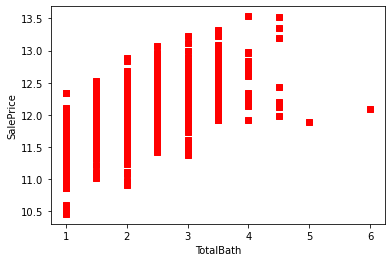

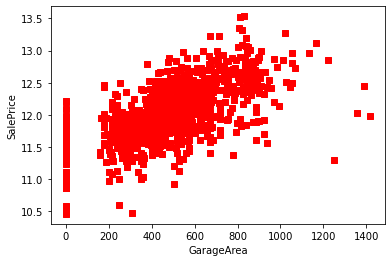

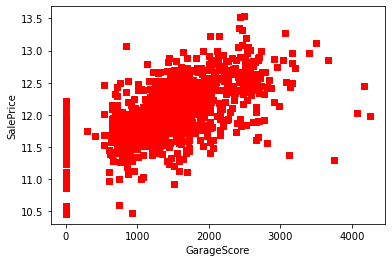

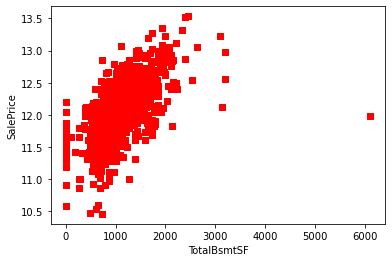

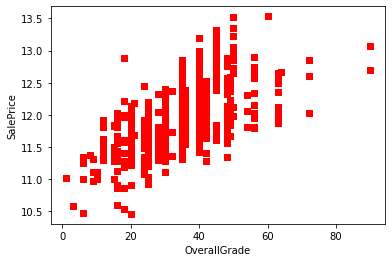

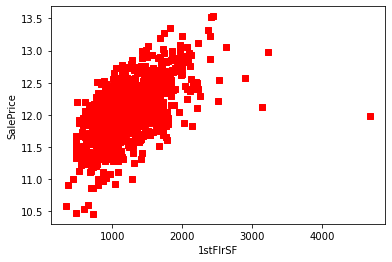

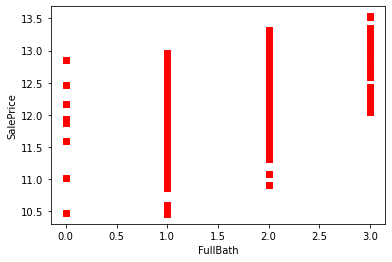

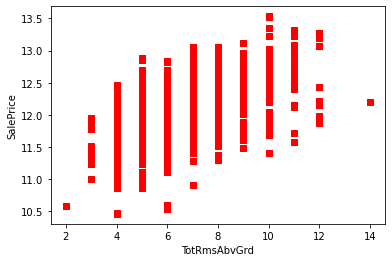

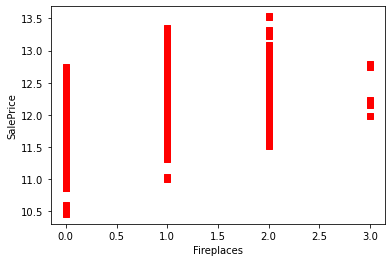

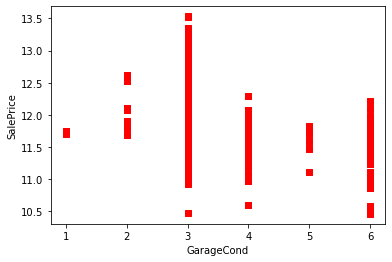

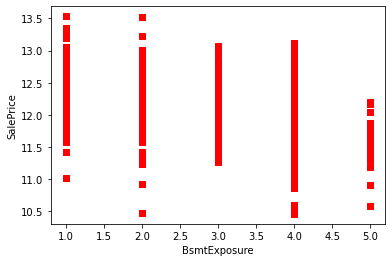

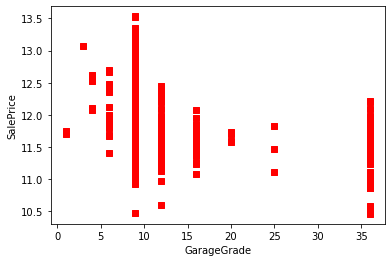

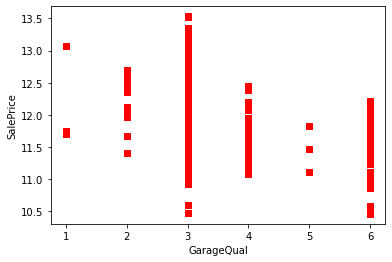

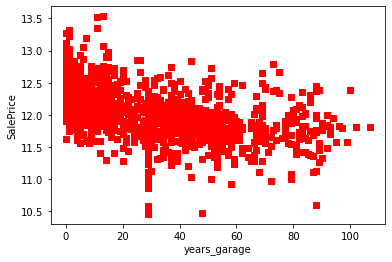

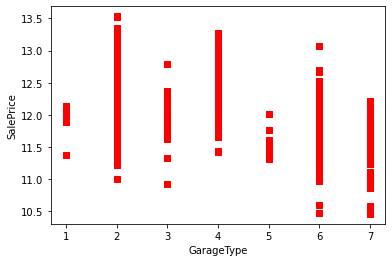

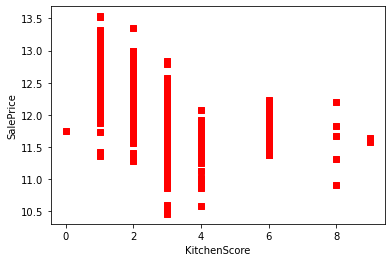

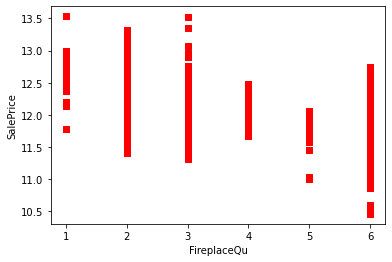

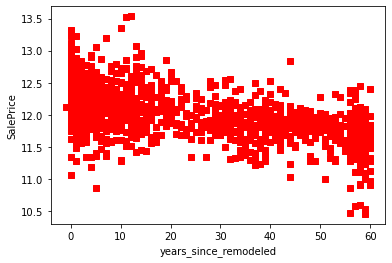

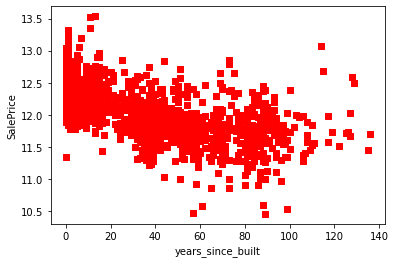

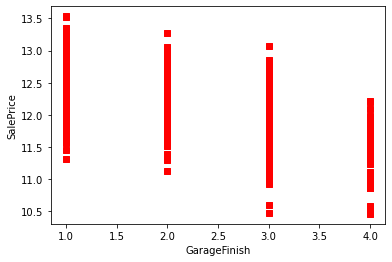

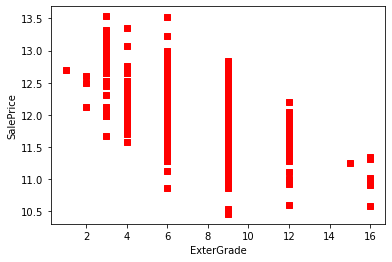

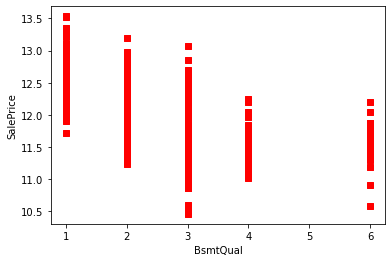

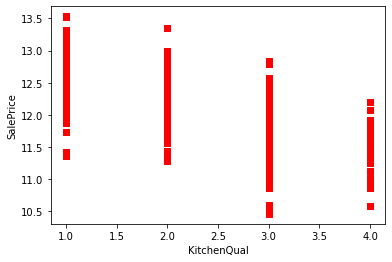

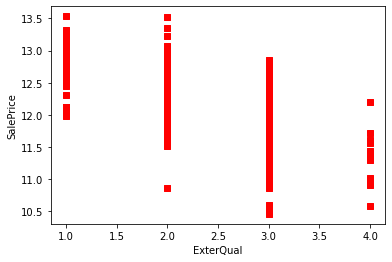

In [ ]:
corr = train.corr()
corr=corr["SalePrice"].sort_values(ascending = False)
cols_with_corr=[]
cols_with_corr+=list(corr[:15].keys()) # with high positive correlation
cols_with_corr+=list(corr[-15:].keys()) # with high negetive correlation
for col in cols_with_corr:
    plt.scatter(train[col], train['SalePrice'], c = "red", marker = "s")
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.show()

Dropping outliers (from the training set). Probably there is some overlap between the following commands, but we will skip a redundant iterative plotting.

In [ ]:
train=df[df['file']=='train']

train=train.drop(train[(train['AllSF']>6000) & (train['SalePrice']<12.5)], errors='ignore')
train=train.drop(train[(train['AllFlrsSF']>4000) & (train['SalePrice']<12.5)], errors='ignore')
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)], errors='ignore')
train=train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<12.5)], errors='ignore')
train=train.drop(train[train['TotalBsmtSF']>5000], errors='ignore')
train=train.drop(train[train['1stFlrSF']>4000], errors='ignore')
train=train.drop(train[(train['GarageScore']>3500) & (train['SalePrice']<12.5)], errors='ignore')
train=train.drop(train[train['OverallGrade']>80], errors='ignore')
train=train.drop(train[train['MasVnrArea']>1200], errors='ignore')

Keeping dimension of X and Y matched by dropping the rows from both X and Y

In [ ]:
Y_train=train['SalePrice']
X_train=train.drop(['SalePrice'], axis=1, errors='ignore')

temp=pd.concat([X_train, Y_train], axis=1)
temp=temp.dropna()
temp=temp.drop(['file'], axis=1, errors='ignore')
Y_train=temp['SalePrice']
X_train=temp.drop(['SalePrice'], axis=1, errors='ignore')

Checking for dimensionality reduction to the many features we have (excluding categoricals).

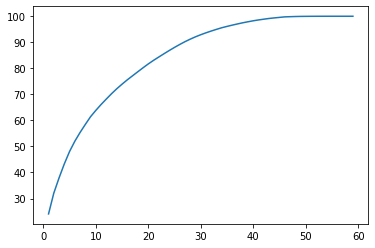

In [ ]:
numerical_columns=X_train.select_dtypes(exclude=['object'])
categorical_columns=X_train.select_dtypes(include=['object']) 

scaler = StandardScaler()
numerical_columns = scaler.fit_transform(numerical_columns)
numerical_columns = pd.DataFrame(numerical_columns)
numerical_columns.columns = X_train.select_dtypes(exclude=['object']).columns

# PCA
pca = PCA(random_state=random_state).fit(numerical_columns)
X_pca_all = pca.transform(numerical_columns)
cumsum = np.cumsum(100*pca.explained_variance_ratio_)
plt.plot(range(1, numerical_columns.shape[1]+1), cumsum)

No point in performing PCA, since the curve is not sharp enough.

In [ ]:
X_train=pd.concat([numerical_columns, categorical_columns], axis=1, ignore_index=True) # after standartization
X_train.columns=list(numerical_columns.columns)+list(categorical_columns.columns)

Prepering the data for ML algorithms

In [ ]:
categorical_columns.drop(columns=['file'], errors='ignore', inplace=True)
OHE = OneHotEncoder(handle_unknown='ignore') # ignore since it runs separately from the test set/
# and might encounter there some new, unknown values.
categorical_columns_OHE = OHE.fit_transform(categorical_columns).toarray()

# Save this onehot encoding object for reuse purpose on the test set
with open('house.pkl', 'wb') as f:
    pickle.dump(OHE, f)

categorical_columns_OHE = pd.DataFrame(categorical_columns_OHE)
X_train_prep = pd.concat([numerical_columns, categorical_columns_OHE], axis=1, ignore_index=True)

# pasting the corresponding columns names
X_train_prep.columns=list(numerical_columns.columns) + list(categorical_columns_OHE.columns)

In [ ]:
X_train_prep.shape

(1456, 231)

In [ ]:
Y_train.shape

(1456,)

**ML ALGORITHMS**

**Support Vector Machine (SVM)**

In [ ]:
param_distribs = {
    'C': uniform(1,10),
    'kernel': ['linear', 'rbf', 'poly']
    }
SVM = RandomizedSearchCV(estimator=SVR(), param_distributions=param_distribs,
                         scoring='neg_root_mean_squared_error', n_iter=10, cv=4,
                         return_train_score=True, random_state=random_state)
SVM.fit(X_train_prep, Y_train);
print ('SVM')
print ('best_model_params: ', SVM.best_estimator_)
print ('best validation score: ', -SVM.best_score_)
print ('corresponding train scores', -SVM.cv_results_['mean_train_score'][SVM.best_index_])

SVM
best_model_params:  SVR(C=2.8343478986616377, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='scale', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)
best validation score:  0.12143593653493315
corresponding train scores 0.09760175811517896


**Random Forest**

In [ ]:
param_distribs = {
     'min_samples_leaf': uniform(0.005,0.020),
     'max_depth': randint(low=15, high=60),
     'n_estimators': [500],
     'random_state' : [random_state]
    }
RF = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_distribs,
                        scoring='neg_root_mean_squared_error', n_iter=20, cv=4,
                        return_train_score=True, random_state=random_state)
RF.fit(X_train_prep, Y_train);
print ('Random Forest')
print ('best_model_params: ', RF.best_estimator_)
print ('best validation score: ', -RF.best_score_)
print ('corresponding train scores', -RF.cv_results_['mean_train_score'][RF.best_index_])

Random Forest
best_model_params:  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=17, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None,
                      min_samples_leaf=0.005411689885916049,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
best validation score:  0.13834520335740297
corresponding train scores 0.09470114442118725


**Gradient Boosting**

In [ ]:
param_distribs = {
    'n_estimators': randint(low=50, high=200),
    'learning_rate': loguniform(0.001, 1),
    'max_depth': randint(low=2, high=10),
    'random_state' : [random_state]
    }
GB = RandomizedSearchCV(estimator=GradientBoostingRegressor(), param_distributions=param_distribs,
                        scoring='neg_root_mean_squared_error', n_iter=10, cv=4,
                        return_train_score=True, random_state=random_state)
GB.fit(X_train_prep, Y_train);
print ('Gradient Boosting')
print ('best_model_params: ', GB.best_estimator_)
print ('best validation score: ', -GB.best_score_)
print ('corresponding train scores', -GB.cv_results_['mean_train_score'][GB.best_index_])

Gradient Boosting
best_model_params:  GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.07119418600172987,
                          loss='ls', max_depth=3, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=71, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
best validation score:  0.12727053560543738
corresponding train scores 0.09246602190557578


Might be worth it giving a shot to mixing 3 different approaches models.

**VotingRegressor:**
using voting with self-defined weights. Robust to either positive/negetive scores.

In [ ]:
all_models=[SVM.best_score_, RF.best_score_, GB.best_score_]
models_sum_of_errors=sum(all_models)
models_weights=[]
my_sum=0
for i in all_models: # 3 iterations
    models_weights.append(models_sum_of_errors/i)
    my_sum+=models_sum_of_errors/i
for i in range(len(all_models)): # 3 iterations- no need to vectorize with numpy...    
    # Noramalizing in order to keep error on the same scale as with the induvidual predictors.
    models_weights[i]=models_weights[i]/my_sum   
print (models_weights)

[0.35311597849413573, 0.30995631589123745, 0.33692770561462676]


In [ ]:
estimators=[('SVM', SVM.best_estimator_), ('RF', RF.best_estimator_),
            ('GB', GB.best_estimator_)]
Vote=VotingRegressor(estimators=estimators, 
                    weights=models_weights)

Vote_CV=cross_validate(Vote, X_train_prep, Y_train, cv=4, scoring='neg_root_mean_squared_error',
                         return_train_score=True)
print ('Voting')
print('Val Error: ', -Vote_CV['test_score'])
print('Train Error: ', -Vote_CV['train_score'])

Voting
Val Error:  [0.10517011 0.13401322 0.11574409 0.11425732]
Train Error:  [0.08855359 0.08080974 0.08822001 0.08706105]


Bar plot of the models validation results (RMSE):

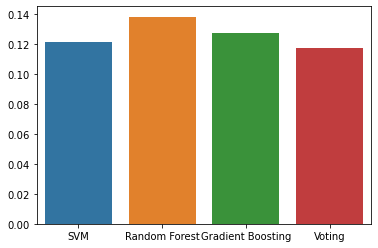

In [ ]:
results=[-SVM.best_score_, -RF.best_score_, -GB.best_score_, -np.mean(Vote_CV['test_score'])]
ax = sns.barplot(x=['SVM', 'Random Forest', 'Gradient Boosting', 'Voting'], y=results)

In [ ]:
categorical_columns

,MSSubClass,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,...,MasVnrType,Foundation,HeatingQC,CentralAir,Electrical,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
1460,20,RH,Lvl,Inside,NAmes,Feedr,1Fam,1Story,Gable,VinylSd,...,None,CBlock,TA,Y,SBrkr,None,6,2010,WD,Normal
1461,20,RL,Lvl,Corner,NAmes,Norm,1Fam,1Story,Hip,Wd Sdng,...,BrkFace,CBlock,TA,Y,SBrkr,Gar2,6,2010,WD,Normal
1462,60,RL,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,...,None,PConc,Gd,Y,SBrkr,None,3,2010,WD,Normal
1463,60,RL,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,...,BrkFace,PConc,Ex,Y,SBrkr,None,6,2010,WD,Normal
1464,120,RL,HLS,Inside,StoneBr,Norm,TwnhsE,1Story,Gable,HdBoard,...,None,PConc,Ex,Y,SBrkr,None,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,Lvl,Inside,MeadowV,Norm,Twnhs,2Story,Gable,CemntBd,...,None,CBlock,Gd,Y,SBrkr,None,6,2006,WD,Normal
2915,160,RM,Lvl,Inside,MeadowV,Norm,TwnhsE,2Story,Gable,CemntBd,...,None,CBlock,TA,Y,SBrkr,None,4,2006,WD,Abnorml
2916,20,RL,Lvl,Inside,Mitchel,Norm,1Fam,1Story,Gable,VinylSd,...,None,CBlock,Ex,Y,SBrkr,None,9,2006,WD,Abnorml
2917,85,RL,Lvl,Inside,Mitchel,Norm,1Fam,SFoyer,Gable,HdBoard,...,None,PConc,TA,Y,SBrkr,Shed,7,2006,WD,Normal


Prepering for testing:

In [ ]:
X_test = df[df['file']=='test'].drop(['SalePrice', 'file'], axis=1, errors='ignore')
numerical_columns = X_test.select_dtypes(exclude=['object'])
categorical_columns = X_test.select_dtypes(include=['object']) 

numerical_columns = scaler.fit_transform(numerical_columns)
numerical_columns = pd.DataFrame(numerical_columns)
numerical_columns.columns = X_test.select_dtypes(exclude=['object']).columns

X_test = pd.concat([numerical_columns, categorical_columns], axis=1, ignore_index=True) # after standartization
X_test.columns = list(numerical_columns.columns)+list(categorical_columns.columns)

with open('house.pkl', 'wb') as f:
    pickle.dump(OHE, f)
categorical_columns_OHE = OHE.transform(categorical_columns).toarray()
categorical_columns_OHE = pd.DataFrame(categorical_columns_OHE)

X_test_prep = pd.concat([numerical_columns, categorical_columns_OHE], axis=1, ignore_index=True)

# pasting the corresponding columns names
X_test_prep.columns=list(numerical_columns.columns) + list(categorical_columns_OHE.columns)

print (X_test_prep.shape)

(1459, 231)


Predictions.

In [ ]:
Vote.fit(X_train_prep, Y_train);
predictions = np.exp(Vote.predict(X_test_prep))

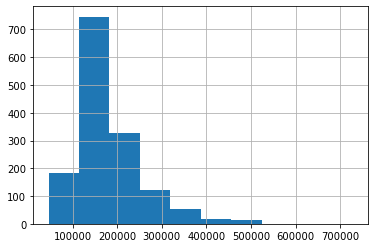

In [ ]:
df_to_csv = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': predictions})
df_to_csv['SalePrice'].hist()

Looks good, just like training target distribution.

In [ ]:
df_to_csv.to_csv('sample_submission.csv', index=False)